In [1]:
%matplotlib inline
import os
import pickle
import math
import random
import pprint
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import sections


In [2]:
rng = np.random.default_rng(42)

In [3]:
# sample a triangular distribution
# params: c (relative position of mode, c=0.5 is symmetric), 
#         loc (lower bound), 
#         scale (width)

# lower, mode, upper
GEO_RANGE = {
    'c2': {
        'h':  (70, 80, 90),
        'tw': (0.8, 1.6, 6),
        'ba': (0, 20, 50),
        'ra': (0.8, 1.6, 12),
        'bf': (0, 20, 50),
        'rf': (0.8, 1.6, 12),    
    },

    'i1': {
        'h':  (70, 80, 90),
        'tw': (0.8, 1.6, 6),
        'ba': (0, 40, 60),
        'ta': (0.8, 1.6, 6),
        'bf': (0, 40, 60),
        'tf': (0.8, 1.6, 6),    
    },
    'l2': {
        'h':  (70, 80, 90),
        'tw': (0.8, 1.6, 6),
        'ba': (0, 40, 80),  # hmm... uniform would make more sense ...
        'ra': (0.8, 3, 12),
    },
    'z3': {
        'h':  (70, 80, 90),
        'tw': (0.8, 1.6, 4),
        'ba': (0, 20, 50),
        'ra': (0.8, 1.6, 12),
        'bf': (0, 20, 50),
        'rf': (0.8, 1.6, 12),    
        'blf': (0, 10, 30),
        'rlf': (0.8, 1.6, 12),    
    },
    'z5': {
        'h':  (40, 60, 80),
        'tw': (0.8, 1.6, 4),
        'ba': (0, 20, 30),
        'ra': (1.6, 1.6, 4),
        'ta': (1.6, 1.6, 4),
        'bf': (0, 20, 30),
        'rf': (1.6, 1.6, 4),    
        'tf': (1.6, 1.6, 4),    
    },
    'z8': {
        'h':  (40, 60, 80),
        'tw': (1, 2, 6),
        'ba': (20, 40, 60),
        'ta': (1, 2, 8),
        'ra': (1, 2, 8),
        'rf': (5, 20, 30),    
    },
    'z9': {
        'h':  (70, 80, 90),
        'tw': (0.8, 1.6, 6),
        'ba': (0, 20, 50),
        'ta': (0.8, 1.6, 6),
        'ra': (0.8, 1.6, 10),
        'bf': (0, 20, 50),
        'tf': (0.8, 1.6, 6),    
        'rf': (0.8, 1.6, 10),    
        'blf': (0, 10, 30),
        'tlf': (0.8, 1.6, 6),    
        'rlf': (0.8, 1.6, 10),    
    },
}

def range_to_triang_params(lower, mode, upper):
    """Return c, loc, scale for triangular distribution -> scipy.stats.triang"""
    loc = lower
    scale = upper - loc
    c = (mode - loc) / scale
    return (c, loc, scale)

In [4]:
# pure random sampling
def sample_triang(section_class, geo_distribution_params, n):
    param_names = section_class.parameter_names
    assert set(param_names) == set(geo_distribution_params.keys()), 'geo param names do not match'
    found = set()
    while len(found) < n:
        sample = []
        for k in param_names:
            v = stats.triang.rvs(*geo_distribution_params[k], random_state=rng)
            sample.append(v)
        try: 
            sec = section_class(*sample)
            sqr_area = math.sqrt(sec.area())
            # dimensions scaled by sqrt(area) 
            values = tuple([x/sqr_area for x in sample])
            found.add(values)
        except ValueError:
            pass

    return pd.DataFrame(list(found), columns=param_names)


In [5]:
TYPES_ANS_CLASSES = {
    'c2': sections.SectionC2, 
    'i1': sections.SectionI1, 
    'l2': sections.SectionL2, 
    'z3': sections.SectionZ3, 
    'z5': sections.SectionZ5, 
    'z8': sections.SectionZ8, 
    'z9': sections.SectionZ9,
}

## try out one section type

In [6]:
sectype = 'c2'
n = 100

geo_dist_params = {k: range_to_triang_params(*v) for k, v in GEO_RANGE[sectype].items()}
pprint.pprint(geo_dist_params)
klass = TYPES_ANS_CLASSES[sectype]
df = sample_triang(klass, geo_dist_params, n)
df.head()

{'ba': (0.4, 0, 50),
 'bf': (0.4, 0, 50),
 'h': (0.5, 70, 20),
 'ra': (0.07142857142857144, 0.8, 11.2),
 'rf': (0.07142857142857144, 0.8, 11.2),
 'tw': (0.15384615384615385, 0.8, 5.2)}


,h,tw,ba,ra,bf,rf
0,5.627290,0.132818,1.438850,0.263680,1.162794,0.596774
1,5.072569,0.131728,1.355995,0.345030,1.741296,0.243799
2,4.078615,0.154547,1.158169,0.163826,1.768758,0.198440
3,5.438833,0.125558,1.558059,0.381749,1.697364,0.587666
4,3.761193,0.202437,0.621261,0.111525,1.278882,0.410345


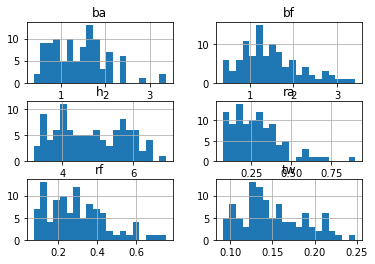

In [7]:
df.hist(bins=20);

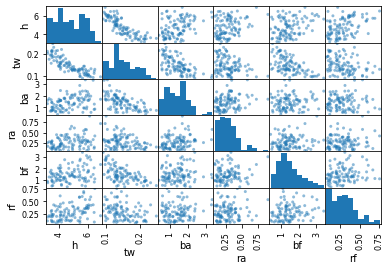

In [8]:
pd.plotting.scatter_matrix(df);

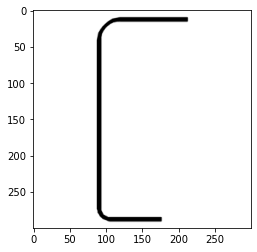

In [9]:
s = klass(*df.iloc[28].values)
#f = s.to_figure()
plt.imshow(s.to_image());

## All Images

### clean/create folder structure 

In [10]:
# create subdirs for phase
basedir = "dataset"
phases = ["train", "val", "test"]
num_images = {
    "train": 4000,
    "val": 1000,
#    "test": 0
}

# create basedir
if not os.path.exists(basedir):
    os.mkdir(basedir)

for phase in phases:
    phasedir = os.path.join(basedir, phase)
    if not os.path.exists(phasedir):
        os.mkdir(phasedir)
    for shapetype in TYPES_ANS_CLASSES.keys():
        subdir = os.path.join(phasedir, shapetype.lower())
        # subdir per shapetype
        if not os.path.exists(subdir):
            os.mkdir(subdir)
        # remove old images
        for fname in os.listdir(subdir):
            os.remove(os.path.join(subdir, fname))


## Create Data

In [11]:
import cv2

def make_images(df, klass, target_dir, figsize=300, pad=10):
    filenames = []
    parameter_names = klass.parameter_names
    for tup in df.itertuples():
        params = [getattr(tup, p) for p in parameter_names]
        shape = klass(*params)    
        img = shape.to_image(figsize=figsize, pad=pad)
        filename = os.path.join(target_dir, "%g.png"%tup.Index)
        cv2.imwrite(filename, img) # RGB
        relpath = os.path.relpath(filename, target_dir)
        filenames.append(relpath)
    df['filename'] = filenames
    #return df

In [12]:
for sectype, klass in TYPES_ANS_CLASSES.items():
    print(sectype)
    dataframes = {}
    i_start = 0
    geo_dist_params = {k: range_to_triang_params(*v) for k, v in GEO_RANGE[sectype].items()}
    for phase, n in num_images.items():
        df = sample_triang(klass, geo_dist_params, n) # unit area; dimensions scaled by sqrt(area)
        df.index += i_start
        i_start += n
        dataframes[phase] = df
    # scaling
    scaler = MinMaxScaler().fit(dataframes['train'])
    scaler_path = os.path.join(basedir, "{}_scaler.pkl".format(sectype.upper()))
    with open(scaler_path, "wb", ) as fp:
        pickle.dump(scaler, fp)
    parameter_names = klass.parameter_names
    scaled_parameter_names = [s+"_scaled" for s in parameter_names]
    for phase in dataframes:
        print(phase)
        df_ = dataframes[phase].copy()
        scaled = scaler.transform(df_[parameter_names].values)
        scaled_df = pd.DataFrame(scaled, columns=scaled_parameter_names, index=df_.index)
        df_new = pd.concat([df_, scaled_df], axis=1)
        # make images
        img_dir = os.path.join(basedir, phase, sectype.lower())
        make_images(df_new, klass, img_dir)
        # store csv
        filename = os.path.join(basedir, "{}_{}.csv".format(sectype.upper(), phase))
        df_new.to_csv(filename, index=True, index_label='id')

c2
train
val
i1
train
val
l2
train
val
z3
train
val
z5
train
val
z8
train
val
z9
train
val
